# Correlation by chance

In this notebook, we reproduce the [spurious correlation](https://tylervigen.com/spurious-correlations) featured by Tyler Vigen between:

- The yearly number of worldwide commercial space launches (source: [Federal Aviation Administration](https://www.census.gov/compendia/statab/2012/tables/12s0822.xls))
- The yearly number of sociology doctorates awarded in the US (source: [National Science Foundation](https://www.nsf.gov/statistics/infbrief/nsf11305/))

These two timeseries contain 13 points (between years 1997 and 2009).

In [1]:
import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

We first construct the two timeseries and compute their Pearson correlation coefficient along with the corresponding p-value.

In [2]:
ts_faa = np.array([54, 46, 42, 50, 43, 41, 46, 39, 37, 45, 45, 41, 54])
ts_nsf = np.array([601, 579, 572, 617, 566, 547, 597, 580, 536, 579, 576, 601, 664])

corr, pval = pearsonr(ts_faa, ts_nsf)

print(f"Correlation = {corr * 100:.2f}% | p-value = {pval:.5f}")

Correlation = 78.91% | p-value = 0.00134


We then sample one million random timeseries of the same length as `ts_faa` and `ts_nsf`. Each point is i.i.d according to a normal distribution with the mean and standard deviation of `ts_faa`.

We then compute the correlation coefficient of each random timeseries with `ts_faa` and compute the fraction of those that are higher or equal to the correlation coefficient between `ts_nsf` and `ts_faa`. This should match almost exactly the p-value computed using the statistical test (only 5 digits are shown here).

In [3]:
num_trials = 1_000_000

data = np.mean(ts_faa) + np.std(ts_faa) * np.random.randn(num_trials, ts_faa.shape[0])

corrs = np.zeros(num_trials)
for i in range(num_trials):
    corrs[i] = pearsonr(data[i,:], ts_faa)[0]

pval_emp = corrs[np.abs(corrs) >= corr].shape[0] / corrs.shape[0] 

print(f"Empirical p-value {pval_emp:.5f}")

Empirical p-value 0.00133


We then plot a small subset of the random timeseries along with `ts_faa` and `ts_nsf`. We also plot the histogram of the correlation coefficients computed in the previous step. The vertical green line shows the correlation between `ts_faa` and `ts_nsf`. The fraction of samples that lie beyond this line represents only 0.134% of the total samples, in agreement with the p-value obtained before.

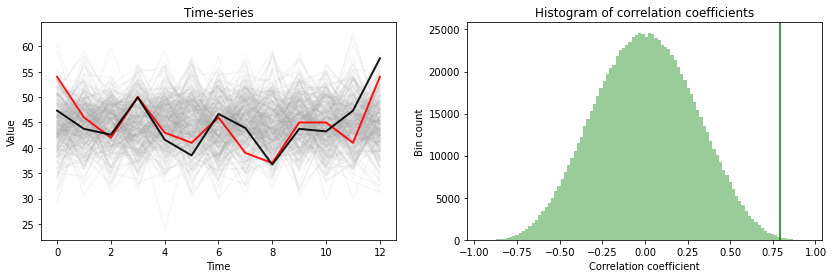

In [4]:
num_trials_to_show = 250

idx = np.random.choice(np.arange(num_trials), size=num_trials_to_show, replace=False)

plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
plt.plot(data[idx, :].T, alpha=0.1, color="#AAAAAA")
plt.plot(ts_faa, alpha=0.9, color="r", linewidth=2)

# re-scale ts2 to match ts1 mean and standard deviation
ts_nsf_ = (ts_nsf - np.mean(ts_nsf)) / np.std(ts_nsf) * np.std(ts_faa) + np.mean(ts_faa)
plt.plot(ts_nsf_, alpha=0.9, color="k", linewidth=2)

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Time-series")

plt.subplot(1, 2, 2)
plt.hist(corrs, 100, color="g", alpha=0.4)
plt.axvline(color="g", x=corr)

plt.xlabel("Correlation coefficient")
plt.ylabel("Bin count")
_ = plt.title("Histogram of correlation coefficients")

Below, we depict the highest scoring time-series in the batch of one million examples, which happens to achieve a Pearson correlation coefficient of more than 90% purely by chance.

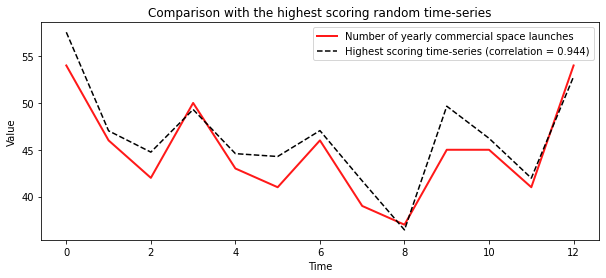

In [5]:
idx_max = np.argmax(corrs)

plt.figure(figsize=(10, 4))

plt.plot(ts_faa, alpha=0.9, color="r", linewidth=2)
plt.plot(data[idx_max, :].T, "k--")

_ = plt.xlabel("Time")
_ = plt.ylabel("Value")
_ = plt.title("Comparison with the highest scoring random time-series")
_ = plt.legend(
    [
        "Number of yearly commercial space launches",
        f"Highest scoring time-series (correlation = {corrs[idx_max]:.3f})",
    ]
)

# Train example

We simulate two processes A and B:

- **Process A** is a Poisson process that represents the arrival of passengers on a train platform. 
- **Process B** is another Poisson process that represents the arrival of trains on the same platform.

The rate of process A is time-varying. Far for from the next train, no passenger comes on the platform, it then grows, until it plateaus at a baseline rate `arrival_rate`. The first figure below depicts this relation. The rate of process B is fixed, and given such that it averages to a given target number of arrivals.

In [6]:
from scipy.stats import poisson, norm
from itertools import takewhile
from math import exp

# simulate 12 hours 
num_steps = 12 * 60
# average number of trains
num_trains = 10
# baseline rate of arrival of passengers
arrival_rate = 0.5

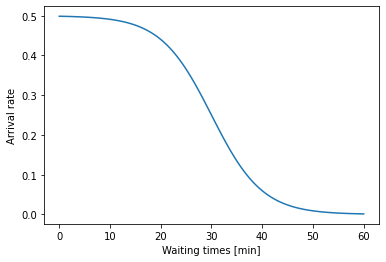

In [7]:
def get_passenger_rate(wait_time: float) -> float:
    return arrival_rate / (1.0 + exp((wait_time - 30) / 5))


wt = np.linspace(0, 60, 100)
_ = plt.plot(wt, np.vectorize(get_passenger_rate)(wt))
_ = plt.xlabel("Waiting times [min]")
_ = plt.ylabel("Arrival rate")

The simulation is very simple: it consists in generating a schedule from a poisson process whose mean is given by: 

$$\lambda = N_{trains} / N_{steps}$$

It then proceeds to iterate over every step and accumulate the number of passengers on the platform by sampling from a Poisson distribution whose rate is given by function `get_passenger_rate`. 

In [8]:
passengers = np.zeros(num_steps)
schedule = np.random.poisson(lam=num_trains / num_steps, size=num_steps)

num_passengers = 0
for i in range(num_steps):
    wait_time = len(list(takewhile(lambda x: x == 0, schedule[i:])))

    # if there is no more train coming, just exit
    if i + wait_time >= num_steps:
        break

    # arrival of people on the platform is proportional to the wait time
    num_passengers += poisson.rvs(get_passenger_rate(wait_time))
    # when the train has arrived in the last minute, everyone hops on the train
    num_passengers = max(0, num_passengers - schedule[i - 1] * num_passengers)

    passengers[i] = num_passengers

corr, pval = pearsonr(passengers, schedule)

We then compute the Pearson correlation coefficient between processes A and B and plot them both. In this context, we assume that process B can be interpreted as a dense binary time-series that equals one when a train arrives and zero everywhere else.

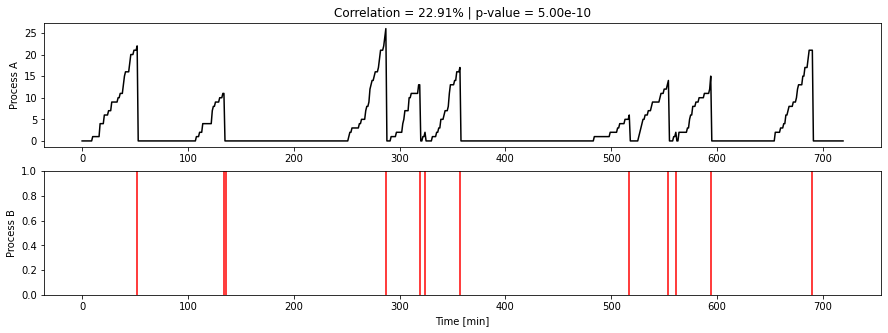

In [9]:
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(2, 1, 1)
_ = plt.title(f"Correlation = {corr * 100:.2f}% | p-value = {pval:.2e}")
_ = plt.plot(passengers, "k")
_ = plt.ylabel("Process A")

ax2 = plt.subplot(2, 1, 2, sharex=ax1)
for x in np.nonzero(schedule)[0]:
    plt.axvline(color="r", x=x)

_ = plt.xlabel("Time [min]")
_ = plt.ylabel("Process B")